In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
%matplotlib inline 

In [4]:
def get_transformed_mnist_data():
    df = pd.read_csv('../data/mnist/train.csv',header=None)
    data = df.iloc[1:].as_matrix().astype(np.float32)
    Y = data[:,0].astype('int')
    X = data[:,1:]
    mu = X.mean(axis=0)
    X -= mu
    pca = PCA()
    Z = pca.fit_transform(X)
    return Z,Y

In [5]:
X,Y = get_transformed_mnist_data()

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,2

In [6]:
def display_sample_image(X,Y):
    labels = ["0","1","2","3","4","5","6","7","8","9"]
    X, Y = shuffle(X,Y)
    for i in xrange(12):
        plt.subplot(3,4,i)
        img = X[i].reshape(28,28)
        plt.imshow(img,cmap='gray')
        plt.axis("off")
        plt.title(labels[Y[i]])
    plt.show()

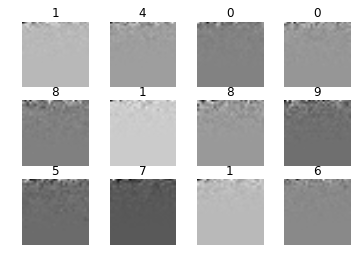

In [7]:
display_sample_image(X,Y)

In [8]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1,keepdims=True)
def cost(T,Y):
    return -(T*np.log(Y)).sum()
def y2indicator(Y):
    N = Y.shape[0]
    K = len(set(Y))
    Y_ind = np.zeros((N,K))
    for i in xrange(N):
        Y_ind[i,Y[i]] = 1
    return Y_ind
def error_rate(targets,predictions):
    return np.mean(targets != predictions)
def relu(x):
    return x*(x>0)
def derivative_w2(Z,T,Y):
    return Z.T.dot(T-Y)
def derivative_b2(T,Y):
    return (T-Y).sum(axis=0)
def derivative_w1(X, Z, T, Y, W2):
#     return X.T.dot((T-Y).dot(W2.T)*Z*(1-Z))
    return X.T.dot((T-Y).dot(W2.T)*(Z>0))
def derivative_b1(Z, T, Y, W2):
#     return ((T-Y).dot(W2.T)*Z*(1-Z)).sum(axis=0)
    return ((T-Y).dot(W2.T)*(Z>0)).sum(axis=0)

In [7]:
class NN(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-8,reg=1e-8,epochs=10000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 5
        self.W1 = np.random.randn(D,M) / np.sqrt(D+M)
        self.b1 = np.zeros(M)
        self.W2 = np.random.randn(M,K) / np.sqrt(M+K)
        self.b2 = np.zeros(K)
        costs = []
        best_validation_error = 1
        for epoch in xrange(epochs):
            P_Y_train, hidden = self.forward(X_train)
            self.W2 += learning_rate*(derivative_w2(hidden,T_train_ind,P_Y_train) + reg*self.W2)
            self.b2 += learning_rate*(derivative_b2(T_train_ind,P_Y_train) + reg*self.b2)
            self.W1 += learning_rate*(derivative_w1(X_train,hidden,T_train_ind,P_Y_train,self.W2)
                                      + reg*self.W1)
            self.b1 += learning_rate*(derivative_b1(hidden,T_train_ind,P_Y_train,self.W2) + 
                                      reg*self.b1)
            if epoch % 1000 == 0:
                P_Y_valid, _ = self.forward(X_valid)
                c = cost(T_valid_ind,P_Y_valid)
                costs.append(c)
                e = error_rate(T_valid,np.argmax(P_Y_valid,axis=1))
                print "epoch: ",epoch, "cost: ",c, "error: ", e
            if e < best_validation_error:
                best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()
    def forward(self,X):
        hidden = relu(X.dot(self.W1) + self.b1)
        A = hidden.dot(self.W2) + self.b2
        expA = np.exp(A)
        Y = expA / expA.sum(axis=1,keepdims=True)
        return Y, hidden 
    def predict(self,X):
        P_Y,_ = self.forward(X)
        return np.argmax(P_Y,axis=1)
    def score(self,X,Y):
        prediction = self.predict(X)
        return 1 - error_rate(prediction,Y)

epoch:  0 cost:  22173.602078 error:  0.823
epoch:  1000 cost:  1161.85144184 error:  0.234
epoch:  2000 cost:  977.794752343 error:  0.201
epoch:  3000 cost:  897.271764794 error:  0.183
epoch:  4000 cost:  690.358688363 error:  0.196
epoch:  5000 cost:  653.560813893 error:  0.193
epoch:  6000 cost:  633.433838278 error:  0.192
epoch:  7000 cost:  619.617660506 error:  0.184
epoch:  8000 cost:  607.318742569 error:  0.175
epoch:  9000 cost:  591.104628787 error:  0.177
best validation error:  0.175


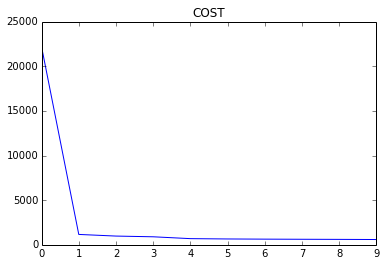

In [8]:
nn_classifier = NN()
nn_classifier.train(X,Y)

## improved the model with batch gradient descent

In [19]:
class NN_batch_gd(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-8,reg=1e-8,epochs=10000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 5
        batch_sz = 500
        n_batches = N / batch_sz
        self.W1 = np.random.randn(D,M) / np.sqrt(D+M)
        self.b1 = np.zeros(M)
        self.W2 = np.random.randn(M,K) / np.sqrt(M+K)
        self.b2 = np.zeros(K)
        costs = []
        best_validation_error = 1
        for epoch in xrange(epochs):
            tmp_X, tmp_Y = shuffle(X_train, T_train_ind)
            for j in xrange(n_batches):
                x = tmp_X[j*batch_sz:(j*batch_sz + batch_sz),:]
                y = tmp_Y[j*batch_sz:(j*batch_sz + batch_sz),:]
                P_Y_train, hidden = self.forward(x)
                self.W2 += learning_rate*(derivative_w2(hidden,y,P_Y_train) + reg*self.W2)
                self.b2 += learning_rate*(derivative_b2(y,P_Y_train) + reg*self.b2)
                self.W1 += learning_rate*(derivative_w1(x,hidden,y,P_Y_train,self.W2)
                                          + reg*self.W1)
                self.b1 += learning_rate*(derivative_b1(hidden,y,P_Y_train,self.W2) + 
                                          reg*self.b1)
            if epoch % 100 == 0:
                    P_Y_valid, _ = self.forward(X_valid)
                    c = cost(T_valid_ind,P_Y_valid)
                    costs.append(c)
                    e = error_rate(T_valid,np.argmax(P_Y_valid,axis=1))
                    print "epoch: ",epoch, "cost: ",c, "error: ", e
                    if e < best_validation_error:
                        best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()
    def forward(self,X):
        hidden = relu(X.dot(self.W1) + self.b1)
        A = hidden.dot(self.W2) + self.b2
        expA = np.exp(A)
        Y = expA / expA.sum(axis=1,keepdims=True)
        return Y, hidden 
    def predict(self,X):
        P_Y,_ = self.forward(X)
        return np.argmax(P_Y,axis=1)
    def score(self,X,Y):
        prediction = self.predict(X)
        return 1 - error_rate(prediction,Y)

epoch:  0 cost:  37580.3124111 error:  0.894
epoch:  100 cost:  3579.427288 error:  0.557
epoch:  200 cost:  2474.77915962 error:  0.46
epoch:  300 cost:  2115.20624693 error:  0.439
epoch:  400 cost:  1946.52861251 error:  0.426
epoch:  500 cost:  1832.6828237 error:  0.412
epoch:  600 cost:  1748.68151758 error:  0.412
epoch:  700 cost:  1675.80204826 error:  0.4
epoch:  800 cost:  1609.63542022 error:  0.396
epoch:  900 cost:  1547.31953434 error:  0.383
epoch:  1000 cost:  1491.25797925 error:  0.34
epoch:  1100 cost:  1435.06873085 error:  0.33
epoch:  1200 cost:  1370.83733691 error:  0.354
epoch:  1300 cost:  1194.94698178 error:  0.276
epoch:  1400 cost:  1127.96421333 error:  0.269
epoch:  1500 cost:  1097.50287069 error:  0.267
epoch:  1600 cost:  1077.8920992 error:  0.26
epoch:  1700 cost:  1062.26377208 error:  0.255
epoch:  1800 cost:  1050.44371179 error:  0.251
epoch:  1900 cost:  1040.88980009 error:  0.252
epoch:  2000 cost:  1034.76101491 error:  0.251
epoch:  2100 c

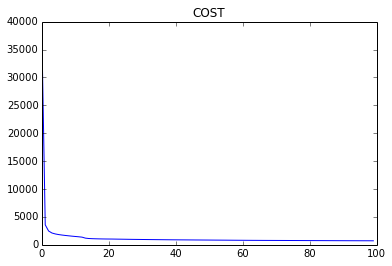

In [20]:
nn_classifier_bgd = NN_batch_gd()
nn_classifier_bgd.train(X,Y)

## improved the model with batch gradient descent and momentum

In [16]:
class NN_batch_gd_momentum(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-8,reg=1e-8,epochs=10000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 300
        batch_sz = 500
        n_batches = N / batch_sz
        self.W1 = np.random.randn(D,M) / np.sqrt(D/2)
        self.b1 = np.zeros(M)
        self.W2 = np.random.randn(M,K) / np.sqrt(M/2)
        self.b2 = np.zeros(K)
        mu = 1e-8
        dW2 = 0
        db2 = 0
        dW1 = 0
        db1 = 0
        costs = []
        best_validation_error = 1
        for epoch in xrange(epochs):
            tmp_X, tmp_Y = shuffle(X_train, T_train_ind)
            for j in xrange(n_batches):
                x = tmp_X[j*batch_sz:(j*batch_sz + batch_sz),:]
                y = tmp_Y[j*batch_sz:(j*batch_sz + batch_sz),:]
                P_Y_train, hidden = self.forward(x)
                #updates
                dW2 = mu*dW2 - learning_rate*(derivative_w2(hidden,y,P_Y_train) + reg*self.W2)
                self.W2 += dW2
                db2 = mu*db2 - learning_rate*(derivative_b2(y,P_Y_train) + reg*self.b2) 
                self.b2 += db2
                dW1 = mu*dW1 - learning_rate*(derivative_w1(x,hidden,y,P_Y_train,self.W2)
                                          + reg*self.W1) 
                self.W1 += dW1
                db1 = mu*db1 - learning_rate*(derivative_b1(hidden,y,P_Y_train,self.W2) + 
                                          reg*self.b1)
                self.b1 += db1
            if epoch % 100 == 0:
                    P_Y_valid, _ = self.forward(X_valid)
                    c = cost(T_valid_ind,P_Y_valid)
                    costs.append(c)
                    e = error_rate(T_valid,np.argmax(P_Y_valid,axis=1))
                    print "epoch: ",epoch, "cost: ",c, "error: ", e
                    if e < best_validation_error:
                        best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()
    def forward(self,X):
        hidden = relu(X.dot(self.W1) + self.b1)
        A = hidden.dot(self.W2) + self.b2
        expA = np.exp(A)
        Y = expA / expA.sum(axis=1,keepdims=True)
        return Y, hidden 
    def predict(self,X):
        P_Y,_ = self.forward(X)
        return np.argmax(P_Y,axis=1)
    def score(self,X,Y):
        prediction = self.predict(X)
        return 1 - error_rate(prediction,Y)

## improved the model with batch gradient descent and RAMSprop

In [64]:
class NN_batch_gd_rmsprop(object):
    def __init__(self):
        pass
    def train(self,X,Y,learning_rate=1e-8,reg=1e-8,epochs=1000,show_fig=True):
        X_train, T_train = X[:-1000],Y[:-1000]
        X_valid, T_valid = X[-1000:], Y[-1000:]
        T_train_ind = y2indicator(T_train)
        T_valid_ind = y2indicator(T_valid)
        N,D = X_train.shape
        K = len(set(T_train))
        M = 300
        batch_sz = 500
        n_batches = N / batch_sz
        self.W1 = np.random.randn(D,M) / np.sqrt(D+M)
        self.b1 = np.zeros(M)
        self.W2 = np.random.randn(M,K) / np.sqrt(M+K)
        self.b2 = np.zeros(K)
        costs = []
        best_validation_error = 1
        lr0 = 1e-6 # the initial learning rate 
        cache_W2 = 0
        cache_b2 = 0
        cache_W1 = 0
        cache_b1 = 0
        decay_rate = 0.999
        eps = 1e-11
        for epoch in xrange(epochs):
            tmp_X, tmp_Y = shuffle(X_train, T_train_ind)
            for j in xrange(n_batches):
                x = tmp_X[j*batch_sz:(j*batch_sz + batch_sz),:]
                y = tmp_Y[j*batch_sz:(j*batch_sz + batch_sz),:]
                P_Y_train, hidden = self.forward(x)
                #update the weights
                # W2 
                grad_W2 = derivative_w2(hidden,y,P_Y_train) + reg*self.W2
                cache_W2 = decay_rate*cache_W2 + (1-decay_rate)*grad_W2*grad_W2
                self.W2 += lr0*grad_W2/(np.sqrt(cache_W2) + eps)
                #b2 
                grad_b2 = derivative_b2(y,P_Y_train) + reg*self.b2
                cache_b2 = decay_rate*cache_b2 + (1-decay_rate)*grad_b2*grad_b2
                self.b2 += lr0*grad_b2/(np.sqrt(cache_b2) + eps)
                #W1
                grad_W1 = derivative_w1(x,hidden,y,P_Y_train,self.W2) + reg*self.W1
                cache_W1 = decay_rate*cache_W1 + (1-decay_rate)*grad_W1*grad_W1
                self.W1 += lr0*grad_W1/(np.sqrt(cache_W1) + eps)
                #b1
                grad_b1 = derivative_b1(hidden,y,P_Y_train,self.W2) + reg*self.b1
                cache_b1 = decay_rate*cache_b1 + (1-decay_rate)*grad_b1*grad_b1
                self.b1 += lr0*grad_b1/(np.sqrt(cache_b1) + eps)
            if epoch % 10 == 0:
                    P_Y_valid, _ = self.forward(X_valid)
                    c = cost(T_valid_ind,P_Y_valid)
                    costs.append(c)
                    e = error_rate(T_valid,np.argmax(P_Y_valid,axis=1))
                    print "epoch: ",epoch, "cost: ",c, "error: ", e
                    if e < best_validation_error:
                        best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()
    def forward(self,X):
        hidden = relu(X.dot(self.W1) + self.b1)
        A = hidden.dot(self.W2) + self.b2
        expA = np.exp(A)
        Y = expA / expA.sum(axis=1,keepdims=True)
        return Y, hidden 
    def predict(self,X):
        P_Y,_ = self.forward(X)
        return np.argmax(P_Y,axis=1)
    def score(self,X,Y):
        prediction = self.predict(X)
        return 1 - error_rate(prediction,Y)

In [52]:
def get_mnist_data():
    df = pd.read_csv('../data/mnist/train.csv',header=None)
    data = df.iloc[1:].as_matrix()
    data = data.astype('int')
    Y = data[:,0]
    X = data[:,1:]/255.0
    return X,Y

In [54]:
X,Y =  get_mnist_data()

epoch:  0 cost:  2255.79046785 error:  0.827
epoch:  10 cost:  2037.04441359 error:  0.476
epoch:  20 cost:  1890.10857271 error:  0.334
epoch:  30 cost:  1756.64484087 error:  0.272
epoch:  40 cost:  1631.04017431 error:  0.235
epoch:  50 cost:  1513.00205522 error:  0.21
epoch:  60 cost:  1403.5034954 error:  0.199
epoch:  70 cost:  1302.65303415 error:  0.192
epoch:  80 cost:  1210.58285603 error:  0.186
epoch:  90 cost:  1126.85399228 error:  0.178
epoch:  100 cost:  1051.21510869 error:  0.169
epoch:  110 cost:  982.993310183 error:  0.165
epoch:  120 cost:  921.639420498 error:  0.165
epoch:  130 cost:  866.451795799 error:  0.156
epoch:  140 cost:  817.01949264 error:  0.156
epoch:  150 cost:  772.719112447 error:  0.157
epoch:  160 cost:  732.977574741 error:  0.154
epoch:  170 cost:  697.339376193 error:  0.152
epoch:  180 cost:  665.324569977 error:  0.148
epoch:  190 cost:  636.551518694 error:  0.148
epoch:  200 cost:  610.596147828 error:  0.146
epoch:  210 cost:  587.1722

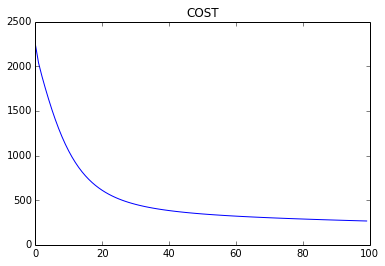

In [55]:
nn_classifier_bgd = NN_batch_gd_rmsprop()
nn_classifier_bgd.train(X,Y)

In [61]:
from six.moves import cPickle

In [63]:
f = open('mnist.ckpt', 'wb')
cPickle.dump(nn_classifier_bgd, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

In [60]:
f = open('mnist.ckpt', 'rb')
mnist_model = cPickle.load(f)
f.close()

In [39]:
def get_mnist_data():
    df = pd.read_csv('../data/mnist/train.csv',header=None)
    data = df.iloc[1:].as_matrix()
    data = data.astype('int')
    Y = data[:,0]
    X = data[:,1:]/255.0
    return X,Y

In [40]:
X_data,Y_data = get_mnist_data()

In [46]:
sample = X_data[0].reshape(1,784)

In [48]:
mnist_model.predict(sample)[0]

9